In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cm
import datetime
from datetime import timedelta
from epiweeks import Week, Year
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import statsmodels.nonparametric.smoothers_lowess as lowess
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
import epiweeks as epi
from scipy.stats import pearsonr as pcr
from scipy.stats import spearmanr as spr
import glob
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
def conv_epiweek(x):
    week=Week.fromdate(pd.to_datetime(x))
    return str(week.year)+'EW'+'{:02}'.format(week.week)

def conv_epiweek_stdate(dt):
    conv_dt=pd.to_datetime(epi.Week.fromdate(pd.to_datetime(dt)).startdate().strftime('%Y-%m-%d'))
    return conv_dt

def get_roll_spear(wwdf,loc,col1,col2,shift=[0]):
    twwdf=wwdf[wwdf.sewershed==loc]
    twwdf=twwdf.set_index('EW_stdate')
    pdf=pd.DataFrame(index=np.arange(0,100),columns=['sewershed','EW_stdate','lag','pcorr','pval'])
    win=12
    k=0
    for j in range(0,100):

        endt=twwdf.index.max()-pd.Timedelta(weeks=j)
        stdt=endt-pd.Timedelta(weeks=win-1)
        if stdt<twwdf.index.min():
            break
        res=(np.nan,0,np.nan)
        for i in shift:
            temp1=twwdf.loc[stdt:endt,col1]
            temp2=twwdf.shift(i).loc[stdt:endt,col2]
            ind=temp2[temp2.notna()].index
            x1=temp1.loc[ind].values
            x2=temp2.loc[ind].values
            px=spr(x1,x2)
    #         print(endt,i,pcr(x1,x2))
            if px[1]<=0.05 and px[0]>res[1]:
                res=(i,px[0],px[1])
#             else:
#                 res=(i,np.nan,px[1])
#         print(endt,res)
            pdf.loc[k,'sewershed']=loc
            pdf.loc[k,'EW_stdate']=endt
            pdf.loc[k,'lag']=res[0]
            pdf.loc[k,'pcorr']=res[1]
            pdf.loc[k,'pval']=res[2]
            k+=1
#         print(j,k,stdt)
    return pdf

In [4]:
ssh_df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/ssh_name_mapping.csv')
ssh_map=dict(zip(ssh_df['new_file_name'],ssh_df['dashboard_name']))

In [6]:
ww2d_df=pd.read_csv('csv/mapping_ss_dist_reg.csv')

In [87]:
hdf=pd.read_csv('input/district_aggregation_CLI_case_wastewater_hosp_facility_CLI_pct_diag_CLI_count_diag_2023-10-22.csv',parse_dates=True)
map_d2r=dict(zip(ww2d_df['VDH_Dist'],ww2d_df['VHASS_Reg']))
hdf.loc[:,'region']=hdf.geo_value.map(map_d2r)
hdf.time_value=pd.to_datetime(hdf.time_value)
hdf.loc[:,'EW']=hdf.time_value.apply(lambda x: conv_epiweek(x))
hdf.loc[:,'EW_stdate']=hdf.time_value.apply(lambda x: conv_epiweek_stdate(x))

In [24]:
ss2d_df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/county_mappings/WWS_to_District_for_agg.csv')

In [25]:
ss2d_map=ss2d_df[['WWS','District']]

In [92]:
temp=hdf[['geo_value','time_value','hosp_fac_BOW_7d_avg','region','EW_stdate','EW']]
rdf=temp.groupby(['region','EW_stdate','EW'],as_index=False).sum()
rdf=rdf.rename(columns={'hosp_fac_BOW_7d_avg':'hosp'})

In [28]:
# for r in rdf.region.unique():
#     rdf[rdf.region==r].plot(x='time_value',y='hosp_fac_BOW_7d_avg',label=r)
#     plt.legend()

In [4]:
# hospdf=pd.read_csv('/project/biocomplexity/COVID-19_commons_tmp//data/VDH_wastewater/processed_data/hosp/sewershed/hosp_agg_latest.csv')
# hospdf.loc[:,'time_value']=pd.to_datetime(hospdf.time_value)
# hospdf.loc[:,'EW']=hospdf.time_value.apply(lambda x: conv_epiweek(x))
# hospdf.loc[:,'EW_stdate']=hospdf.time_value.apply(lambda x: conv_epiweek_stdate(x))

In [15]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons_tmp//data/opioids_url/Sewershed_PCR_Conc.csv',date_parser=True)
df.sample_collect_date=pd.to_datetime(df.sample_collect_date)
df.test_result_date=pd.to_datetime(df.test_result_date)
df.loc[:,'EW']=df.sample_collect_date.apply(lambda x: conv_epiweek(x))
df.loc[:,'EW_stdate']=df.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))
temp=df.groupby(['sewershed','EW']).size().reset_index().rename(columns={0:'no_of_samples'})
df=df.merge(temp)
df.loc[:,'sewershed']=df.sewershed.replace(ssh_map)

In [16]:
ww_ss_map=dict(df[['wwtp_name','sewershed']].drop_duplicates().values)

In [7]:
cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/opioids_url/Sewershed_Case_Counts.csv",parse_dates=['event_date'])
cdf=cases.pivot(index='sewershed',columns='event_date',values='count')
cdf.columns=pd.to_datetime(cdf.columns)
wcdf=cdf.resample('W-SAT',axis=1).sum()
wcdf.columns=wcdf.columns-pd.Timedelta(days=6)
wcdf=wcdf.melt(ignore_index=False,var_name='EW_stdate',value_name='cases').reset_index()

In [8]:
wdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/wastewater/sewershed/ww_agg_latest.csv')
wdf.loc[:,'time_value']=pd.to_datetime(wdf.time_value)
# len(wdf[wdf.time_value>='2023-05-01'].geo_value.unique())

In [9]:
bdf=pd.read_csv('input/sewershed_aggregation_case_wastewater_hosp_facility_2023-10-08.csv',parse_dates=['time_value'])
wcdf=bdf[['geo_value','time_value','BOW_cases']].rename(columns={'geo_value':'sewershed','time_value':'EW_stdate','BOW_cases':'cases'})

In [10]:
j=0
for i in df.wwtp_name.unique():
    if df[df.wwtp_name==i]['EW_stdate'].max().strftime('%Y-%m-%d') >='2023-06-01':
        print(i, df[df.wwtp_name==i]['EW_stdate'].min(),df[df.wwtp_name==i]['EW_stdate'].max())
        j+=1
print(j)

HRSD: Virginia Initiative Plant 2021-09-12 00:00:00 2023-10-22 00:00:00
Moores Creek Advanced Water Resource Rec 2021-09-12 00:00:00 2023-10-22 00:00:00
HRSD: Nansemond 2021-09-12 00:00:00 2023-10-22 00:00:00
H.L. Mooney Advanced Water Reclamation F 2021-09-12 00:00:00 2023-10-22 00:00:00
HRSD: Onancock 2021-09-12 00:00:00 2023-10-22 00:00:00
Richmond Wastewater Treatment Plant 2021-09-12 00:00:00 2023-10-22 00:00:00
Alexandria Renew Enterprises 2021-09-12 00:00:00 2023-10-22 00:00:00
Upper Occoquan Service Authority Regiona 2021-09-12 00:00:00 2023-10-22 00:00:00
Parkins Mill Wastewater Treatment Facili 2021-09-12 00:00:00 2023-10-22 00:00:00
North River Wastewater Treatment Facilit 2021-09-12 00:00:00 2023-10-22 00:00:00
HRSD: Williamsburg 2021-09-12 00:00:00 2023-10-22 00:00:00
Lynchburg Water Resource Recovery Facili 2021-09-12 00:00:00 2023-10-22 00:00:00
Blacksburg-VPI Sanitation Authority 2021-09-12 00:00:00 2023-10-22 00:00:00
Pound Wastewater Treatment Plant 2021-09-12 00:00:0

In [55]:
map_ss2r=dict(zip(ww2d_df['sewershed'],ww2d_df['VHASS_Reg']))
map_ss2r['Tazewell_T']='Far SW'
map_ss2r['Halifax_T']='Central'
map_ss2r['LowerJ_T']='Near SW'
map_ss2r['LowMoor_T']='Near SW'
map_ss2r['Arlington_T']='Northern'

In [127]:
rdf

,region,EW_stdate,EW,hosp
0,Central,2020-03-01,2020EW10,0.000000
1,Central,2020-03-08,2020EW11,0.000000
2,Central,2020-03-15,2020EW12,0.000000
3,Central,2020-03-22,2020EW13,0.000000
4,Central,2020-03-29,2020EW14,0.000000
...,...,...,...,...
1143,Northwest,2023-09-24,2023EW39,3.174672
1144,Northwest,2023-10-01,2023EW40,2.937195
1145,Northwest,2023-10-08,2023EW41,3.505561
1146,Northwest,2023-10-15,2023EW42,3.834558


In [107]:
alldf.loc[:,'region']=alldf.sewershed.map(map_ss2r)

In [108]:
# ddf=df[df.no_of_samples==2]
# temp1=ddf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([min]).reset_index().rename(columns={'min':'sample_collect_date'})
# temp1.loc[:,'test']='test1'
# temp2=ddf.groupby(['EW','wwtp_name'])['sample_collect_date'].agg([max]).reset_index().rename(columns={'max':'sample_collect_date'})
# temp2.loc[:,'test']='test2'
# temp1=temp1.append(temp2)
# ddf=ddf.merge(temp1)

In [109]:
alldf=pd.read_csv('output/sewershed_test_types.csv')

### Generate correlations

In [130]:
predf=alldf[(alldf.EW_stdate<'2022-09-18')&(alldf.test=='one_test')]
pre_two_locs=predf.sewershed.unique()

coly='log_viral_load'
colx='hosp'

for tts in ['pre_two_tests']:#['test1','test2','mean_test','one_test']:
    allspdf=pd.DataFrame()
    topspdf=pd.DataFrame()
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test' or tts=='pre_two_tests':
        samp='one_tests'
#     stdf=alldf[alldf.test==tts]
#     slocs=stdf.sewershed.unique()
    for l in pre_two_locs:
        mdf=pd.read_csv('output/slope_pct_v2/{}_{}_{}_ST.csv'.format(l,tts,samp))
        mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
        mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))
        mdf.loc[:,'region']=mdf.sewershed.map(map_ss2r)


        htemp=rdf[rdf.region==map_ss2r[l]]
        codf=mdf.merge(htemp)

    # #     temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]
        temp=codf[['EW_stdate',colx,coly,'sewershed']]

        spdf=get_roll_spear(temp,l,col1=colx,col2=coly,shift=[-2,-1,0,1,2])
        spdf.loc[:,'EW_stdate']=pd.to_datetime(spdf['EW_stdate'])
#         spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
        spdf.pcorr=spdf.pcorr.fillna(0)
        idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
        bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
        spdf=spdf.merge(bspdf,'outer')
        spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
        allspdf=allspdf.append(spdf)
        topspdf=topspdf.append(bspdf)
        print(codf.EW_stdate.max(),l)
    allspdf.to_csv('output/hosp_corr_ss/{}_{}_{}.csv'.format(colx,tts,samp),index=None)
    topspdf.to_csv('output/hosp_corr_ss/top_{}_{}_{}.csv'.format(colx,tts,samp),index=None)
    
for tts in ['test1','test2','mean_test','one_test']:
    allspdf=pd.DataFrame()
    topspdf=pd.DataFrame()
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test' or tts=='pre_two_tests':
        samp='one_tests'
    stdf=alldf[alldf.test==tts]
    slocs=stdf.sewershed.unique()
    for l in slocs:
        mdf=pd.read_csv('output/slope_pct_v2/{}_{}_{}_ST.csv'.format(l,tts,samp))
        mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
        mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


        htemp=rdf[rdf.region==map_ss2r[l]]
        codf=mdf.merge(htemp)

    # #     temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]
        temp=codf[['EW_stdate',colx,coly,'sewershed']]

        spdf=get_roll_spear(temp,l,col1=colx,col2=coly,shift=[-2,-1,0,1,2])
#         spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
        spdf.pcorr=spdf.pcorr.fillna(0)
        idx=spdf[spdf.pval<=0.05].groupby('EW_stdate',dropna=False)['pcorr'].idxmax()
        bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
        spdf=spdf.merge(bspdf,'outer')
        spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
        allspdf=allspdf.append(spdf)
        topspdf=topspdf.append(bspdf)
        print(codf.EW_stdate.max(),l)
    allspdf.to_csv('output/hosp_corr_ss/{}_{}_{}.csv'.format(colx,tts,samp),index=None)
    topspdf.to_csv('output/hosp_corr_ss/top_{}_{}_{}.csv'.format(colx,tts,samp),index=None)

2022-09-11 00:00:00 Virginia Initiative Plant
2022-09-11 00:00:00 Nansemond
2022-09-11 00:00:00 HL Mooney
2022-09-11 00:00:00 Onancock
2022-09-11 00:00:00 Richmond
2022-09-11 00:00:00 Upper Occoquan
2022-09-04 00:00:00 Williamsburg
2022-09-11 00:00:00 Pound
2022-09-11 00:00:00 Aquia
2022-09-11 00:00:00 Little Falls Run
2022-09-11 00:00:00 Wolf Creek
2022-09-11 00:00:00 HRSD_ATCE
2022-08-28 00:00:00 Tazewell_T
2022-08-28 00:00:00 Lebanon
2022-08-28 00:00:00 Hillsville
2022-09-04 00:00:00 Clintwood
2023-09-17 00:00:00 Parkins Mill
2023-09-17 00:00:00 Alexandria Renew
2023-09-17 00:00:00 North River
2023-09-17 00:00:00 Blacksburg
2023-09-17 00:00:00 Pepper's Ferry
2023-09-17 00:00:00 Roanoke
2023-09-17 00:00:00 Coeburn Norton Wise
2023-09-17 00:00:00 Moores Creek
2023-09-17 00:00:00 Lynchburg
2023-09-17 00:00:00 LowerJ_T
2023-09-17 00:00:00 LowMoor_T
2023-09-17 00:00:00 RockyMount
2023-09-17 00:00:00 Arlington_T
2023-09-17 00:00:00 Parkins Mill
2023-09-17 00:00:00 Alexandria Renew
2023-09

In [92]:
locs=df.sewershed.unique()
i=1
curr_ss=[]
for l in locs:
    temp=df[df.sewershed==l]['EW_stdate']
    if temp.max()<pd.to_datetime('2023-08-01'):
        print(l,temp.min(),temp.max())
    else:
        print(i,l,temp.min(),temp.max())
        curr_ss.append(l)
        i+=1

HRSD_AT 2021-09-12 00:00:00 2021-12-05 00:00:00
1 Virginia Initiative Plant 2021-09-12 00:00:00 2023-10-08 00:00:00
2 Moores Creek 2021-09-12 00:00:00 2023-10-08 00:00:00
3 Nansemond 2021-09-12 00:00:00 2023-10-08 00:00:00
Danville 2021-09-12 00:00:00 2022-07-24 00:00:00
4 HL Mooney 2021-09-12 00:00:00 2023-10-08 00:00:00
5 Onancock 2021-09-12 00:00:00 2023-10-08 00:00:00
6 Richmond 2021-09-12 00:00:00 2023-10-08 00:00:00
7 Alexandria Renew 2021-09-12 00:00:00 2023-10-08 00:00:00
RutledgeCreek 2021-09-12 00:00:00 2022-07-24 00:00:00
8 Upper Occoquan 2021-09-12 00:00:00 2023-10-08 00:00:00
9 Parkins Mill 2021-09-12 00:00:00 2023-10-08 00:00:00
10 North River 2021-09-12 00:00:00 2023-10-08 00:00:00
11 Williamsburg 2021-09-12 00:00:00 2023-10-08 00:00:00
Purcellville 2021-09-12 00:00:00 2022-07-17 00:00:00
12 Lynchburg 2021-09-12 00:00:00 2023-10-08 00:00:00
13 Blacksburg 2021-09-12 00:00:00 2023-10-08 00:00:00
Christiansburg 2021-09-12 00:00:00 2022-07-24 00:00:00
14 Pound 2021-09-12 00:

In [131]:
sgt=rdf[rdf.EW_stdate>='2021-10-01'].groupby('EW_stdate').sum().reset_index()

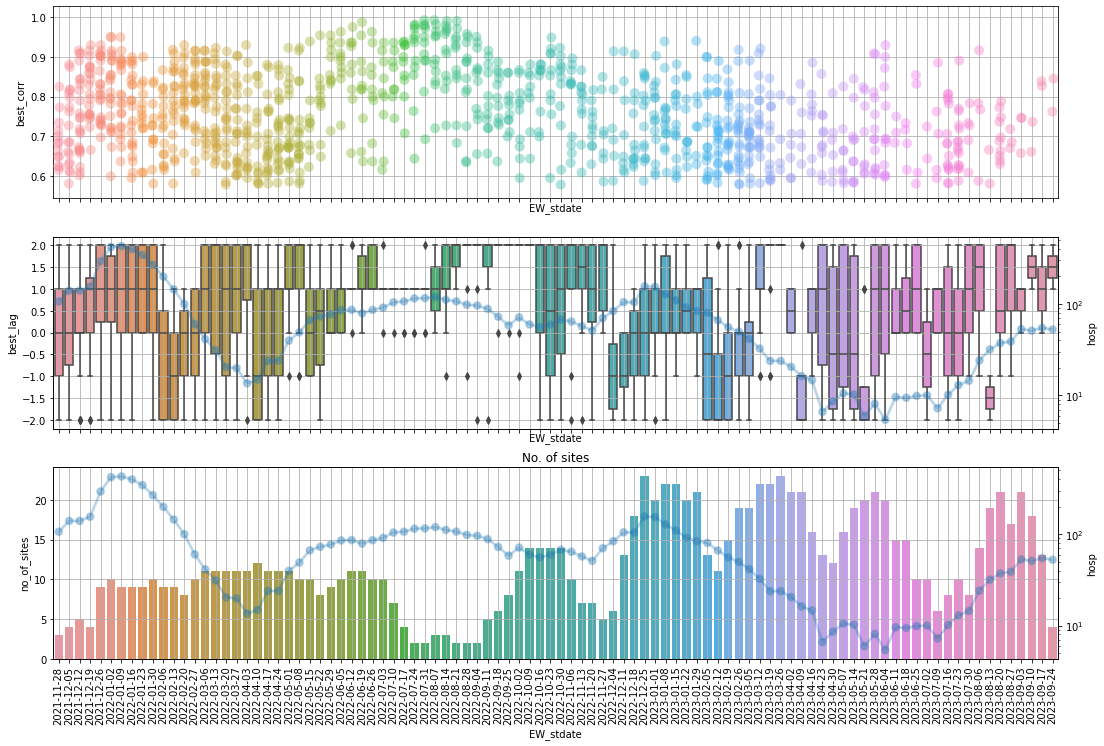

In [132]:
sur='hosp'
allspdf=pd.DataFrame()
for tts in ['pre_two_tests','one_test','test2']:
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test' or tts=='pre_two_tests':
        samp='one_tests'
    temp=pd.read_csv('output/hosp_corr_ss/{}_{}_{}.csv'.format(sur,tts,samp))
    allspdf=allspdf.append(temp)
allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate'],dropna=False).mean()[['best_corr']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
# pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
# pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})


bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
pp
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
# pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
# pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})

ppl=bestspdf[bestspdf.best_corr>0].groupby(['sewershed','EW_stdate'],dropna=False).mean()[['best_lag']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
# ppl.EW_stdate=ppl.EW_stdate.dt.strftime('%Y-%m-%d')
# ppl=ppl.sort_values('EW_stdate')

fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.stripplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>=0],size=10,ax=ax,alpha = 0.4)
ax.grid()
# ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
# sns.stripplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1,alpha = 0.4)
sns.boxplot(x='EW_stdate', y='best_lag', data=ppl,ax=ax1)

ax1.grid()
ax1twin=ax1.twinx()
# ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)
dates=ppl.EW_stdate.unique()
pltsgt=sgt[sgt.EW_stdate.isin(dates)]
sns.pointplot(ax=ax1twin,x='EW_stdate',y='hosp',data=pltsgt,plot_kws=dict(alpha=0.3))
plt.setp(ax1twin.collections, alpha=.3) #for the markers
plt.setp(ax1twin.lines, alpha=.3)       #for the lines
ax1twin.set_yscale('log')
ax1twin.set_alpha(0.3)



ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites',ax=ax2)
ax2.grid()
# xticks = ax2.get_xticklabels()
# ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')
xdates=pd.to_datetime(sorted(pp.EW_stdate.unique())).strftime('%Y-%m-%d')
ax2.set_xticklabels(labels=xdates, rotation=90);
# plt.xticks(rotation=45);
plt.xticks(rotation=90);
# ax3=axr[3]


ax2twin=ax2.twinx()
dates=counts.EW_stdate.unique()
pltsgt=sgt[sgt.EW_stdate.isin(dates)]
sns.pointplot(ax=ax2twin,x='EW_stdate',y='hosp',data=pltsgt,plot_kws=dict(alpha=0.3))
plt.setp(ax2twin.collections, alpha=.3) #for the markers
plt.setp(ax2twin.lines, alpha=.3)       #for the lines
ax2twin.set_yscale('log')
ax2twin.set_alpha(0.3)
ax2twin.set_xticklabels(labels=xdates, rotation=90);
# plt.xticks(rotation=45);
# plt.savefig('plots/corr_lag_barplot.pdf',bbox_inches='tight')

In [374]:
pp.dtypes

sewershed            object
EW_stdate    datetime64[ns]
best_corr           float64
dtype: object

In [243]:
sur='cases'
allspdf=pd.DataFrame()
for tts in ['pre_two_tests','one_test','test2']:
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test' or tts=='pre_two_tests':
        samp='one_tests'
    temp=pd.read_csv('output/corr_ss/t{}_{}_{}.csv'.format(sur,tts,samp))
    allspdf=allspdf.append(temp,ignore_index=True)
allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])

In [244]:
allspdf

,sewershed,EW_stdate,lag,pcorr,pval,best_lag,best_corr,best_pval
0,Virginia Initiative Plant,2022-09-11,-2.0,0.0,0.214492,NaN,NaN,NaN
1,Virginia Initiative Plant,2022-09-11,-1.0,0.0,0.769875,NaN,NaN,NaN
2,Virginia Initiative Plant,2022-09-11,0.0,0.0,0.931234,NaN,NaN,NaN
3,Virginia Initiative Plant,2022-09-11,1.0,0.0,0.931234,NaN,NaN,NaN
4,Virginia Initiative Plant,2022-09-11,2.0,0.0,0.354148,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12985,NaN,NaT,NaN,0.0,NaN,NaN,NaN,NaN
12986,NaN,NaT,NaN,0.0,NaN,NaN,NaN,NaN
12987,NaN,NaT,NaN,0.0,NaN,NaN,NaN,NaN
12988,NaN,NaT,NaN,0.0,NaN,NaN,NaN,NaN


In [282]:
# sur='cases'
# allspdf=pd.DataFrame()
# for tts in ['pre_two_tests','one_test','test2']:
#     if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
#         samp='two_tests'
#     elif tts=='one_test' or tts=='pre_two_tests':
#         samp='one_tests'
#     temp=pd.read_csv('output/corr_ss/top_{}_{}_{}.csv'.format(sur,tts,samp))
#     allspdf=allspdf.append(temp,ignore_index=True)
# allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
# # bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
# # bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)

# colname='best_corr'
# temp=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']]#.drop_duplicates()
# idx=temp.groupby(['sewershed','EW_stdate'])['best_corr'].idxmax()
# btemp=temp.loc[idx]
# ind=btemp[(btemp.best_corr==0)|(btemp.best_corr.isna())].index
# btemp.loc[ind,'best_lag']=np.nan
# btemp=btemp.drop_duplicates()
# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values=colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# melt_temp=ptemp.melt(ignore_index=False,value_name=colname).reset_index()
# sns.stripplot(x='EW_stdate', y=colname, data=melt_temp,size=10,ax=ax,alpha = 0.4)
# ax.grid()
# ax.set_title(colname)

# colname='best_lag'
# temp=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']]#.drop_duplicates()
# idx=temp.groupby(['sewershed','EW_stdate'])['best_corr'].idxmax()
# btemp=temp.loc[idx]
# ind=btemp[(btemp.best_corr==0)|(btemp.best_corr.isna())].index
# btemp.loc[ind,'best_lag']=np.nan
# btemp=btemp.drop_duplicates()
# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values=colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# melt_temp=ptemp.melt(ignore_index=False,value_name=colname).reset_index()
# melt_temp.groupby('EW_stdate')['best_lag'].value_counts().unstack(1).plot.bar(stacked=True,ax=ax)
# ax.grid()
# ax.set_title(colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# counts=melt_temp.dropna(subset=['best_lag']).groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})
# sns.barplot(data=counts,x='EW_stdate',y='no_of_sites',ax=ax)
# ax.grid()

In [283]:
# sur='cases'
# allspdf=pd.DataFrame()
# for tts in ['pre_two_tests','one_test','test2']:
#     if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
#         samp='two_tests'
#     elif tts=='one_test' or tts=='pre_two_tests':
#         samp='one_tests'
#     temp=pd.read_csv('output/corr_ss/top_{}_{}_{}.csv'.format(sur,tts,samp))
#     allspdf=allspdf.append(temp,ignore_index=True)
# allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
# # bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
# # bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)

# colname='best_corr'
# temp=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']]#.drop_duplicates()
# idx=temp.groupby(['sewershed','EW_stdate'])['best_corr'].idxmax()
# btemp=temp.loc[idx]
# ind=btemp[(btemp.best_corr==0)|(btemp.best_corr.isna())].index
# btemp.loc[ind,'best_lag']=np.nan
# btemp=btemp.drop_duplicates()
# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values=colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# melt_temp=ptemp.melt(ignore_index=False,value_name=colname).reset_index()
# sns.stripplot(x='EW_stdate', y=colname, data=melt_temp,size=10,ax=ax,alpha = 0.4)
# ax.grid()
# ax.set_title(colname)

# colname='best_lag'
# temp=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']]#.drop_duplicates()
# idx=temp.groupby(['sewershed','EW_stdate'])['best_corr'].idxmax()
# btemp=temp.loc[idx]
# ind=btemp[(btemp.best_corr==0)|(btemp.best_corr.isna())].index
# btemp.loc[ind,'best_lag']=np.nan
# btemp=btemp.drop_duplicates()
# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values=colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# melt_temp=ptemp.melt(ignore_index=False,value_name=colname).reset_index()
# sns.stripplot(x='EW_stdate', y=colname, data=melt_temp,size=10,ax=ax,alpha = 0.4)
# ax.grid()
# ax.set_title(colname)

# fig,axr=plt.subplots(1,1,figsize=(18,5),sharex=True)
# ax=axr
# counts=melt_temp.dropna(subset=['best_lag']).groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})
# sns.barplot(data=counts,x='EW_stdate',y='no_of_sites',ax=ax)
# ax.grid()

In [263]:
s

In [286]:
sur='cases'
allspdf=pd.DataFrame()
for tts in ['one_test','pre_two_tests','mean_test']:
    if (tts=='test1') or (tts=='test2') or (tts=='mean_test'):
        samp='two_tests'
    elif tts=='one_test' or tts=='pre_two_tests':
        samp='one_tests'
    temp=pd.read_csv('output/corr_ss/top_{}_{}_{}.csv'.format(sur,tts,samp))
    allspdf=allspdf.append(temp,ignore_index=True)
allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])



temp=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']]#.drop_duplicates()
idx=temp.groupby(['sewershed','EW_stdate'])['best_corr'].idxmax()
btemp=temp.loc[idx]
ind=btemp[(btemp.best_corr==0)|(btemp.best_corr.isna())].index
btemp.loc[ind,'best_lag']=np.nan
btemp=btemp.drop_duplicates()



# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values='best_corr')
# fig,ax=plt.subplots(figsize=(25,10))
# sns.heatmap(ptemp.fillna(0),ax=ax,vmin=0,vmax=1)
# ax.set_title('best_corr')


# ptemp=btemp.pivot(index='sewershed',columns='EW_stdate',values='best_lag')
# fig,ax=plt.subplots(figsize=(25,10))
# sns.heatmap(ptemp.fillna(0),ax=ax,vmin=-2,vmax=2,)
# ax.set_title('best_lag')

In [292]:
all_dates=df.EW_stdate.unique()
all_dates=all_dates[(all_dates<=allspdf.EW_stdate.max())&((all_dates>=allspdf.EW_stdate.min()))]
corr_df=pd.DataFrame(index=curr_ss,columns=all_dates)
for l in curr_ss:
    loc_dates=btemp[btemp.sewershed==l]['EW_stdate'].unique()
    corr_df.loc[l,loc_dates]=btemp[btemp.sewershed==l]['best_corr'].values
    
lag_df=pd.DataFrame(index=curr_ss,columns=all_dates)
for l in curr_ss:
    loc_dates=btemp[btemp.sewershed==l]['EW_stdate'].unique()
    lag_df.loc[l,loc_dates]=btemp[btemp.sewershed==l]['best_lag'].values

corr_df=corr_df.astype(float)
lag_df=lag_df.astype(float)

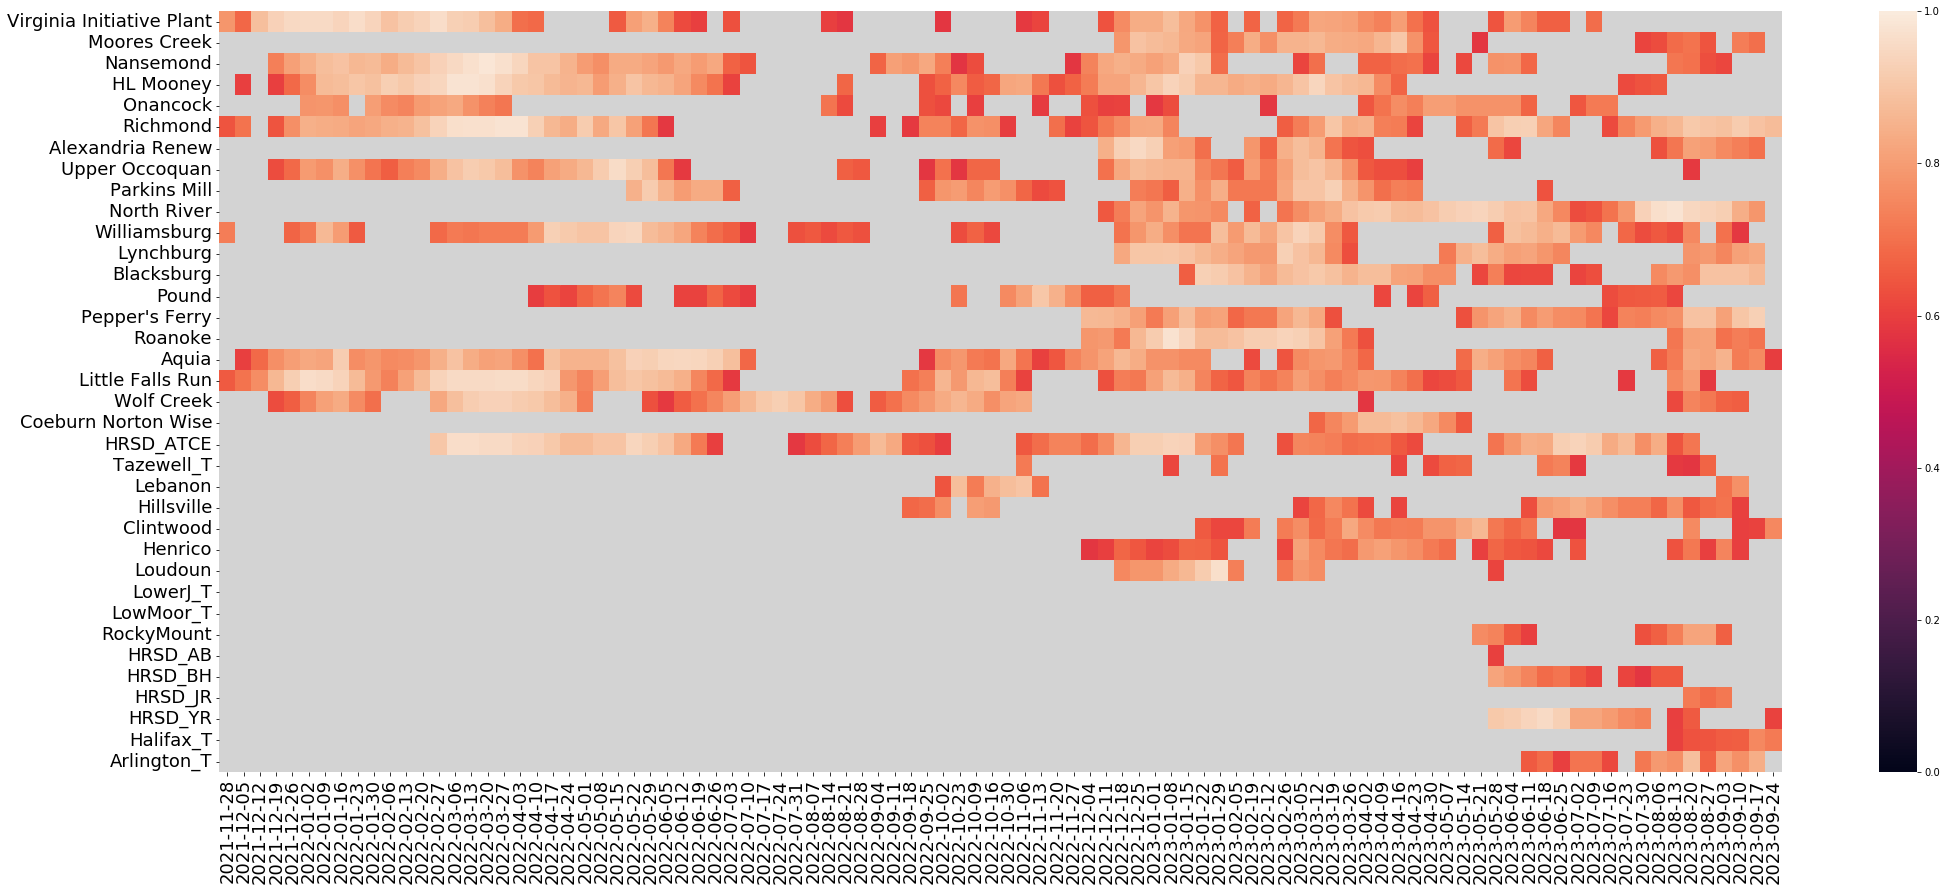

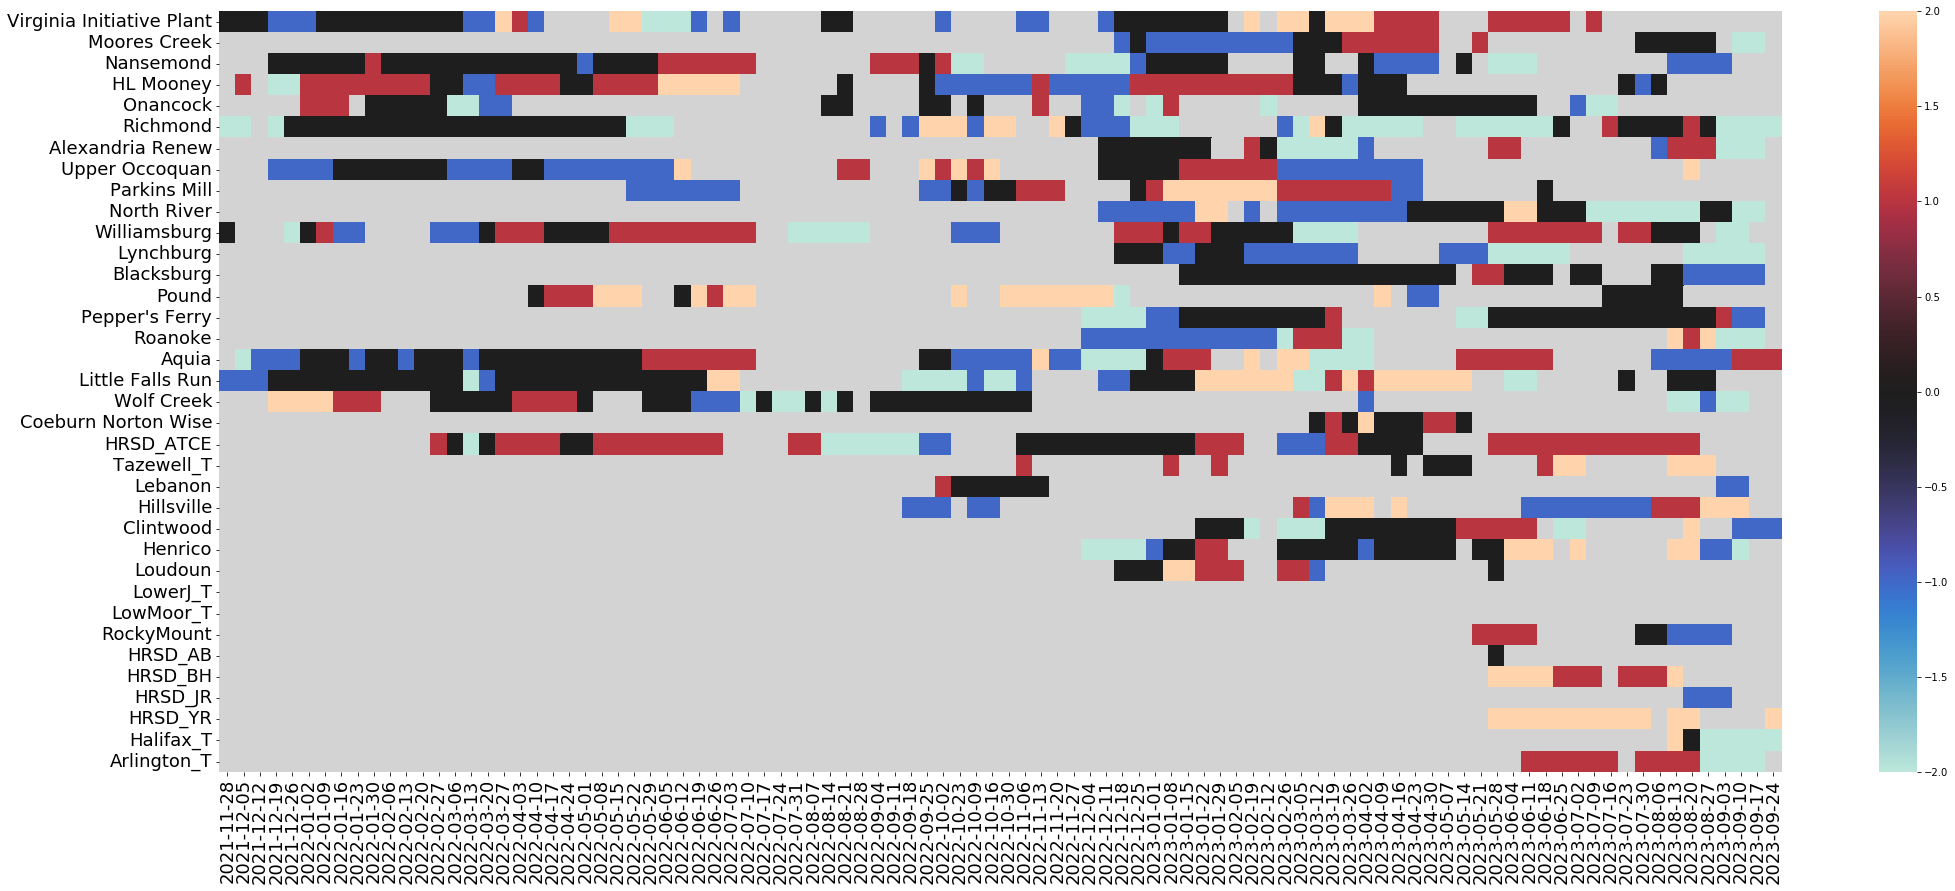

In [327]:
fig,ax=plt.subplots(figsize=(35,14))
cmap=sns.color_palette("rocket", as_cmap=True)
cmap.set_bad('#D3D3D3')
sns.heatmap(corr_df,ax=ax,cmap=cmap,vmax=1,vmin=0,mask=corr_df.isna())
ax.set_xticklabels(corr_df.columns.strftime('%Y-%m-%d'))
plt.xticks(rotation=90)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('plots/correlation_latest.pdf',bbox_inches='tight')


fig,ax=plt.subplots(figsize=(35,14))
cmap=sns.color_palette("icefire", as_cmap=True)
cmap.set_bad('#D3D3D3')
sns.heatmap(lag_df,ax=ax,cmap=cmap,vmax=2,vmin=-2)
ax.set_xticklabels(corr_df.columns.strftime('%Y-%m-%d'))
plt.xticks(rotation=90)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('plots/lag_latest.pdf',bbox_inches='tight')

In [386]:
corr_df.loc[:,'2023-01-01':].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/all_ss_BoY.xlsx')
corr_df.iloc[:,-4:].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/all_ss_last4weeks.xlsx')

In [392]:
lag_df.loc[:,'2023-01-01':].median(axis=1).sort_values(ascending=True).to_excel('results/lag_all_ss_BoY.xlsx')
lag_df.iloc[:,-4:].median(axis=1).sort_values(ascending=True).to_excel('results/lag_all_ss_last4weeks.xlsx')


In [366]:
corr_df.loc[:,'2023-01-01':].fillna(0).mean(axis=1).sort_values(ascending=False)#.to_excel('results/all_ss_BoY.xlsx')

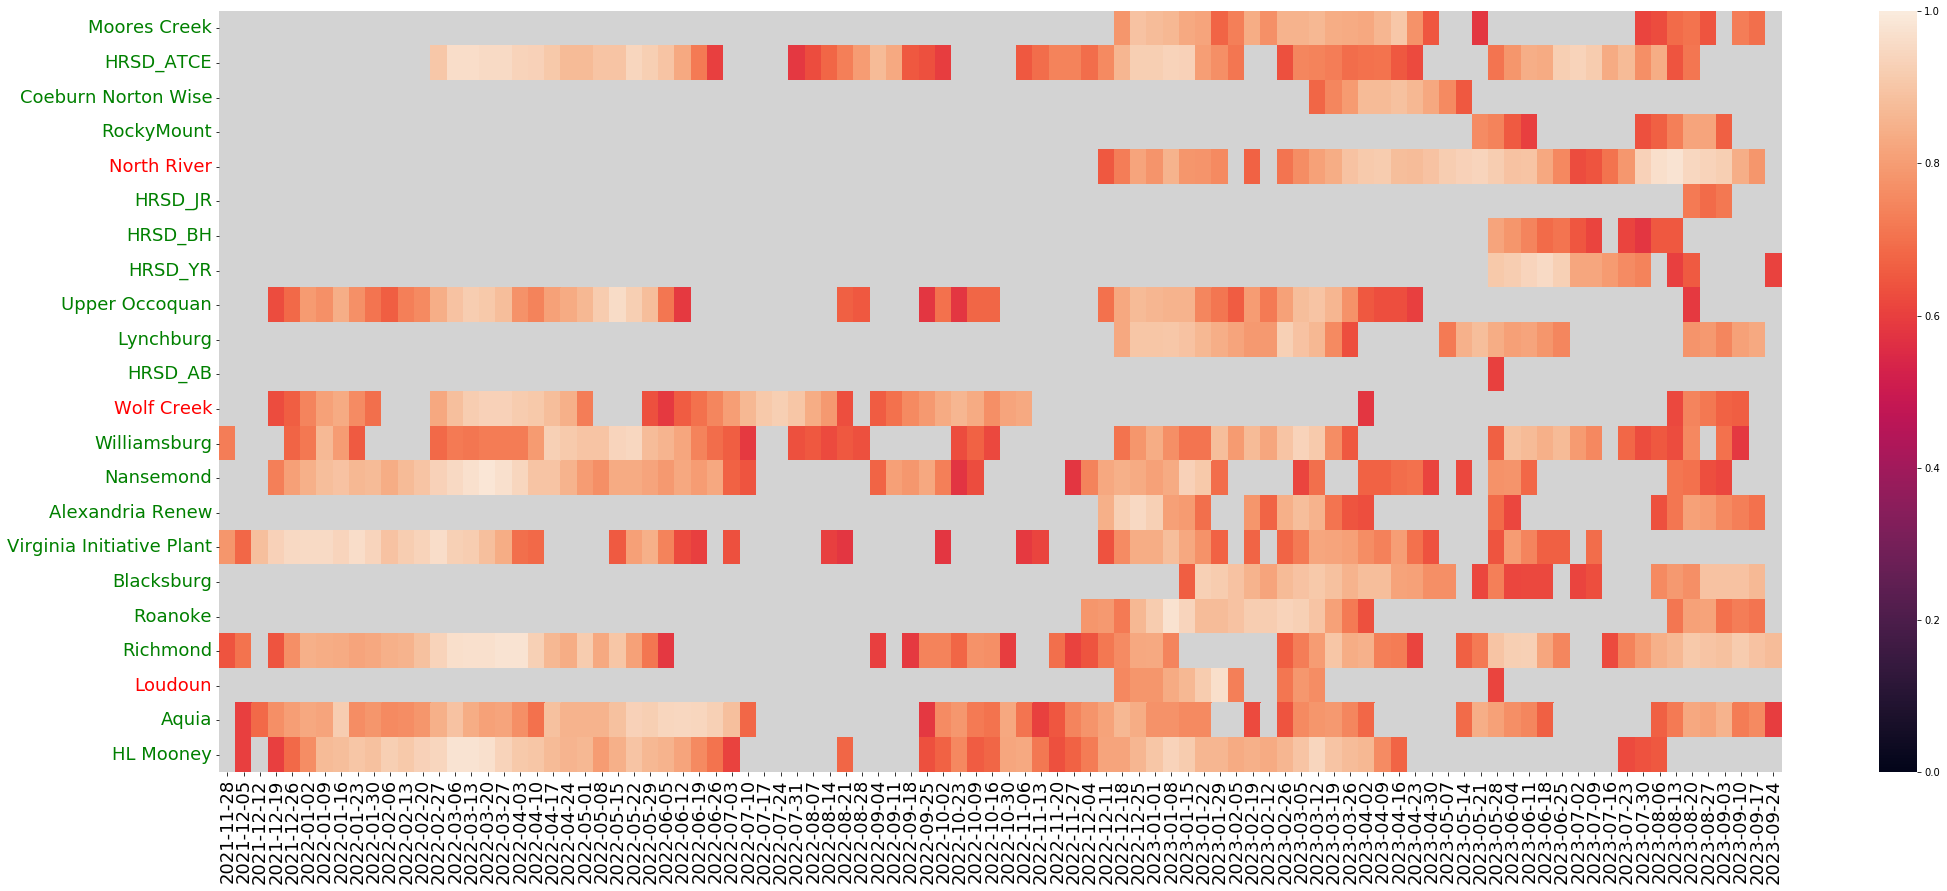

In [367]:
ss_hospdf=pd.read_csv('input/sewersheds_with_hc_and_hosp.csv')
ss_hospdf.wwtp=ss_hospdf.wwtp.str.strip().values
ss_hospdf.wwtp=ss_hospdf.wwtp.replace(ww_ss_map)
ss_hospdf=ss_hospdf.rename(columns={'wwtp':'sewershed'})
ss_hospdf=ss_hospdf.sort_values('hosp_likely_in_ss')
hosp_ss=ss_hospdf.sewershed.unique()
with_hosp_ss=list(set(corr_df.index).intersection(set(hosp_ss)))


fig,ax=plt.subplots(figsize=(35,14))
cmap=sns.color_palette("rocket", as_cmap=True)
cmap.set_bad('#D3D3D3')
sns.heatmap(corr_df.loc[with_hosp_ss,:],ax=ax,cmap=cmap,vmax=1,vmin=0)
ax.set_xticklabels(corr_df.columns.strftime('%Y-%m-%d'))
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    ll=tick_label.get_text()
    if not (ss_hospdf[ss_hospdf['sewershed']==ll]['hosp_likely_in_ss'].empty):
        if (ss_hospdf[ss_hospdf['sewershed']==ll]['hosp_likely_in_ss']==1).values[0]:
            
            tick_label.set_color("green")
        elif (ss_hospdf[ss_hospdf['sewershed']==ll]['hosp_likely_in_ss']==0).values[0]:
            tick_label.set_color("red")  
plt.xticks(rotation=90)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('plots/correlation_latest_with_hosp.pdf',bbox_inches='tight')

In [406]:
corr_df.loc[with_hosp_ss,'2023-01-01':].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/hosp_ss_BoY.xlsx')
corr_df.loc[with_hosp_ss,'2023-08-28':].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/hosp_ss_last4weeks.xlsx')

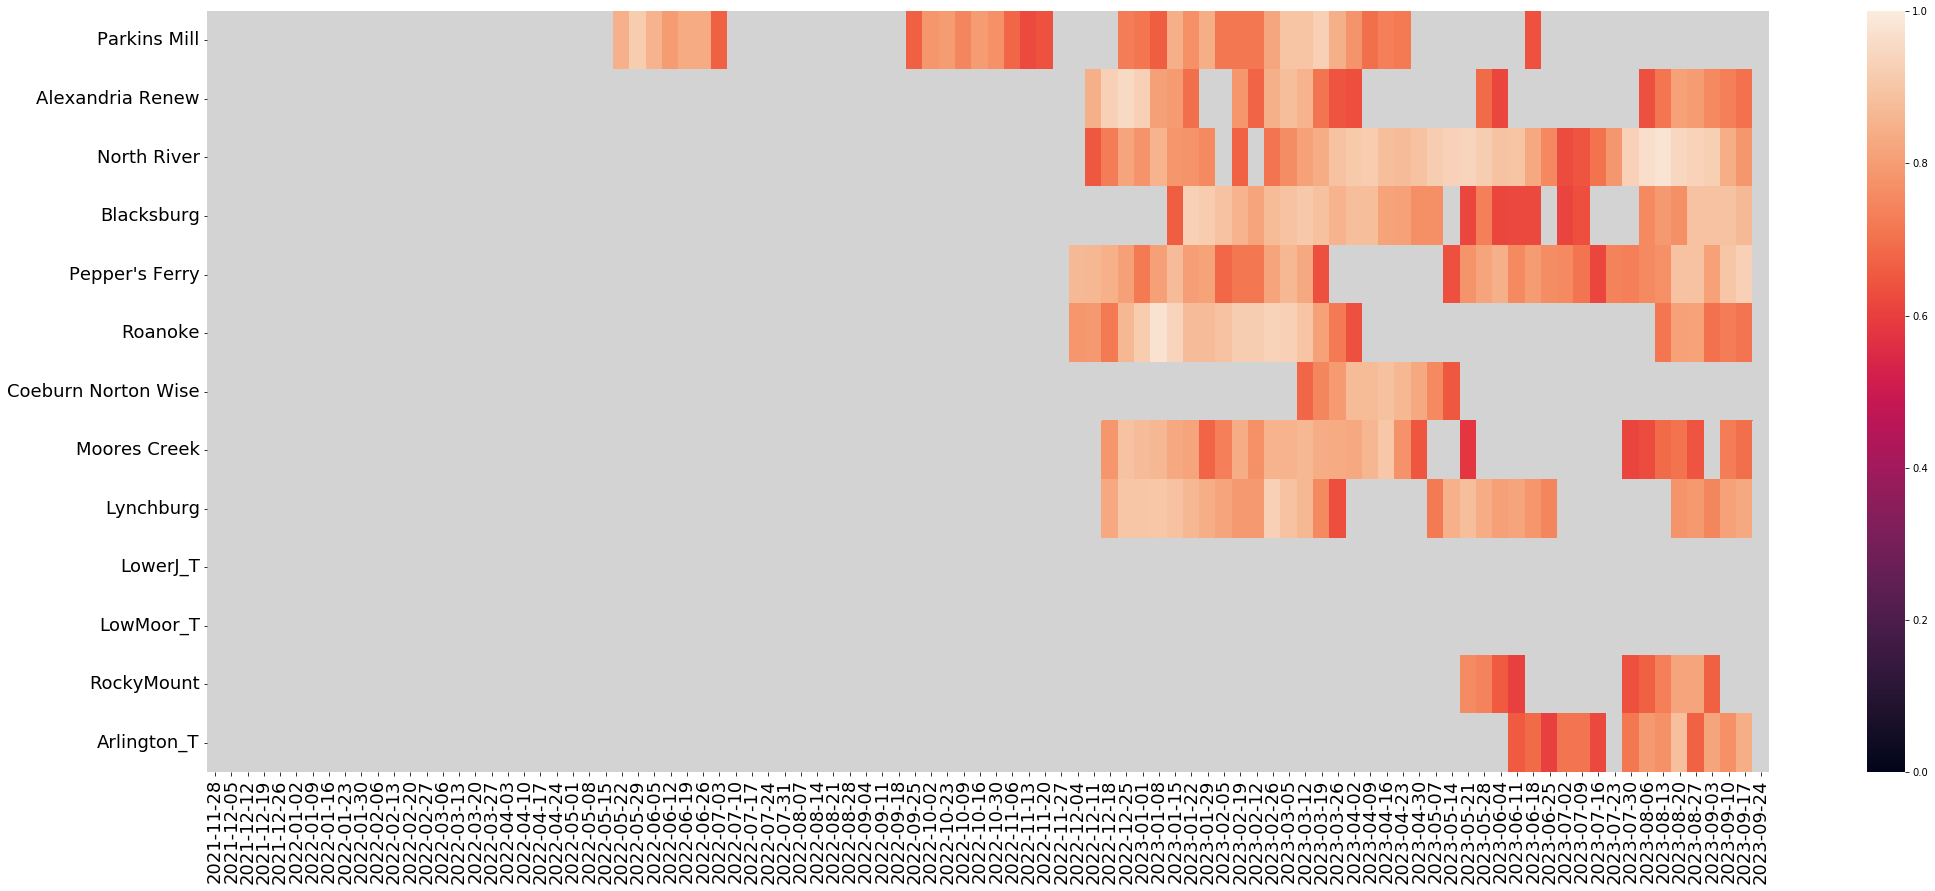

In [335]:
two_samp_locs=df[df.no_of_samples==2].sewershed.unique()
fig,ax=plt.subplots(figsize=(35,14))
cmap=sns.color_palette("rocket", as_cmap=True)
cmap.set_bad('#D3D3D3')
sns.heatmap(corr_df.loc[two_samp_locs],ax=ax,cmap=cmap,vmax=1,vmin=0)
ax.set_xticklabels(corr_df.columns.strftime('%Y-%m-%d'))
# for i, tick_label in enumerate(ax.axes.get_yticklabels()):
#     ll=tick_label.get_text()
#     if ll in two_samp_locs:
#         tick_label.set_color("magenta")
plt.xticks(rotation=90)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('plots/correlation_latest_two_samples.pdf',bbox_inches='tight')

In [79]:
two_samp_locs=df[df.no_of_samples==2].sewershed.unique()

In [402]:
corr_df.loc[two_samp_locs,'2023-01-01':].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/two_samp_ss_BoY.xlsx')
corr_df.loc[with_hosp_ss,'2023-08-28':].fillna(0).mean(axis=1).sort_values(ascending=False).to_excel('results/two_samp_ss_last4weeks.xlsx')

In [414]:
print(corr_df.loc[:,'2023-01-01':].fillna(0).mean(axis=1).mean())
print(corr_df.loc[:,'2023-01-01':].fillna(0).mean(axis=1).quantile(q=.05),corr_df.loc[:,'2023-01-01':].fillna(0).mean(axis=1).quantile(q=.95))

0.3350787721948879
0.011617946713820484 0.6234396711930545


In [416]:
print(corr_df.loc[two_samp_locs,'2023-01-01':].fillna(0).mean(axis=1).mean())
print(corr_df.loc[two_samp_locs,'2023-01-01':].fillna(0).mean(axis=1).quantile(q=.05),corr_df.loc[two_samp_locs,'2023-01-01':].fillna(0).mean(axis=1).quantile(q=.95))

0.37872672757518394
0.0 0.6904764121755322


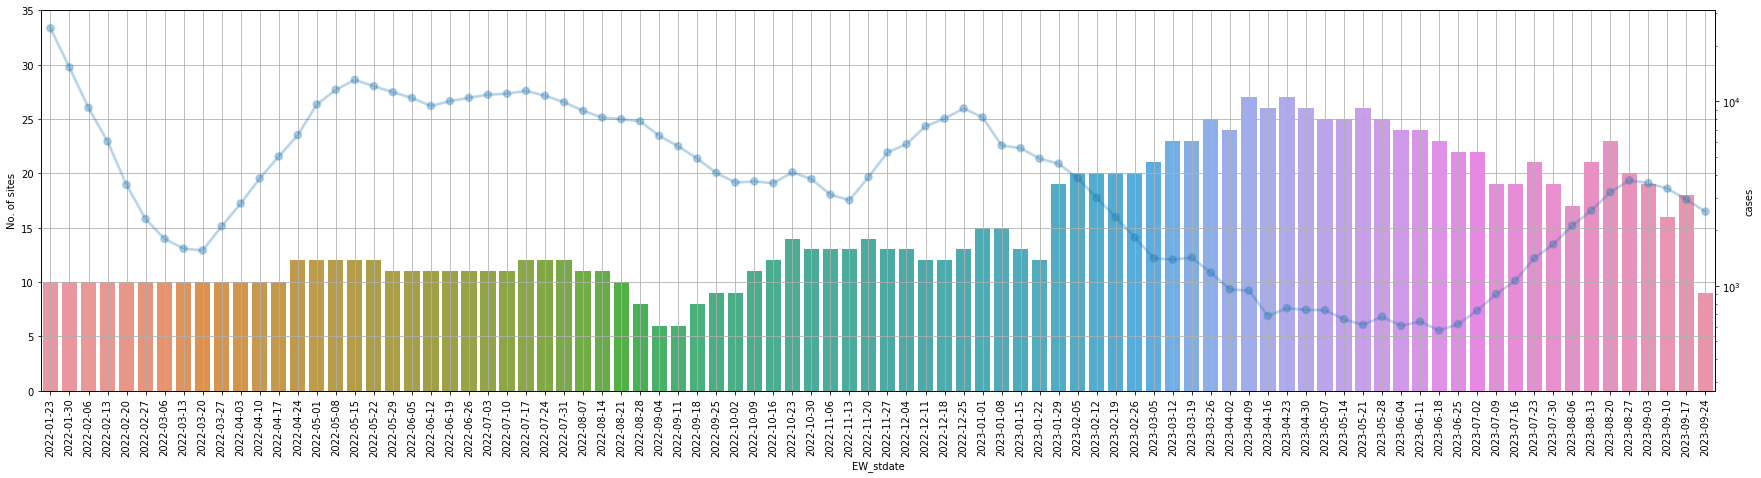

In [210]:
counts=corr_df.copy()
counts[counts.notna()]=1
mcounts=counts.melt(ignore_index=False,var_name=['EW_stdate'],value_name='No. of sites').reset_index().rename(columns={'index':'sewershed'})

fig,ax=plt.subplots(figsize=(30,7))
plt_mcounts=mcounts.groupby(['EW_stdate'],as_index=False).sum()
sns.barplot(data=plt_mcounts,x='EW_stdate',y='No. of sites',ax=ax)
ax.set_ylim([0,35])
ax.grid()
xticks = ax.get_xticklabels();
ax.set_xticklabels(xticks,rotation=90);
ax1twin=ax.twinx()
dates=plt_mcounts.EW_stdate
pltsgt=sgt[sgt.EW_stdate.isin(dates)]
sns.pointplot(ax=ax1twin,x='EW_stdate',y='cases',data=pltsgt,plot_kws=dict(alpha=0.3))
plt.setp(ax1twin.collections, alpha=.3) #for the markers
plt.setp(ax1twin.lines, alpha=.3)       #for the lines
ax1twin.set_yscale('log')
ax1twin.set_alpha(0.3)
ax1twin.set_xticklabels(plt_mcounts.EW_stdate.dt.strftime('%Y-%m-%d'));
# ax1twin.set_xticks(rotation=90);


Text(0.5, 1.0, 'best lags')

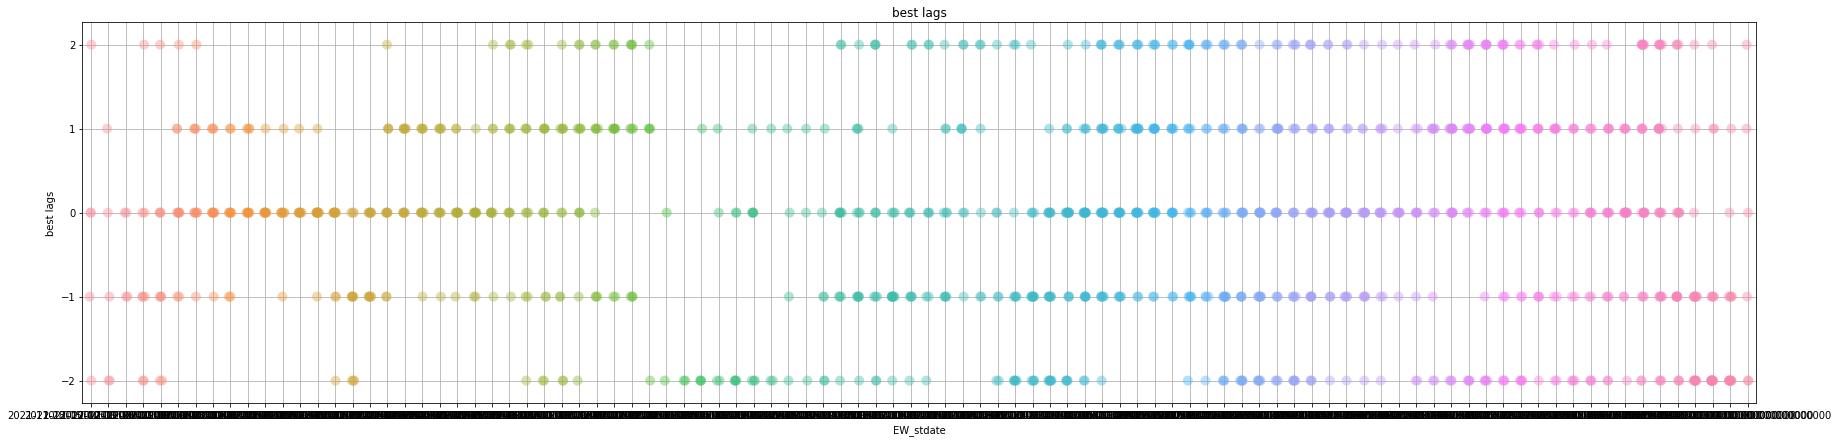

In [201]:
lcounts=lag_df.copy()
# lcounts[lcounts.notna()]=1

fig,ax=plt.subplots(figsize=(30,7))

mlcounts=lcounts.melt(ignore_index=False,var_name=['EW_stdate'],value_name='best lags').reset_index().rename(columns={'index':'sewershed'})
sns.stripplot(x='EW_stdate', y='best lags', data=mlcounts,size=10,ax=ax,alpha = 0.4)
ax.grid()
ax.set_title('best lags')

In [81]:
sgt=wcdf[wcdf.EW_stdate>='2021-10-01'].groupby('EW_stdate').sum().reset_index()
# sgt.EW_stdate=sgt.EW_stdate.dt.strftime('%Y-%m-%d')


SpearmanrResult(correlation=0.01042260571554394, pvalue=0.9672595356962199)

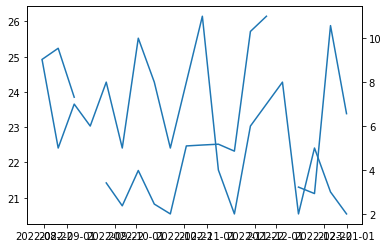

In [143]:
l='Clintwood'
d='2023-01-01'
temp=bdf[(bdf.geo_value==l)&(bdf.time_value<=d)&(bdf.time_value>='2022-01-01')]
_,ax=plt.subplots()
lag=20
ax.plot(temp[-lag:]['time_value'],np.log(temp[-lag:]['viral_load']))
ax2=ax.twinx()
ax2.plot(temp[-lag:]['time_value'],(temp[-lag:]['BOW_cases']))
x=np.log(temp[-lag:]['viral_load']).replace(-np.inf,np.nan).dropna()
indx=x.index
y=temp.loc[indx,'BOW_cases']
spr(x,y)

In [139]:
x

1086    24.923809
1087    25.238006
1088    23.849925
1089          NaN
1090    21.418881
1091    20.768716
1092    21.771187
1093    20.818287
1094    20.539234
1095    22.467598
1096    22.493777
1097    22.517293
1098    22.320043
1099    25.715249
1100    26.146490
1101          NaN
1102    21.300121
1103    21.116652
1104    25.880931
1105    23.382939
Name: viral_load, dtype: float64

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

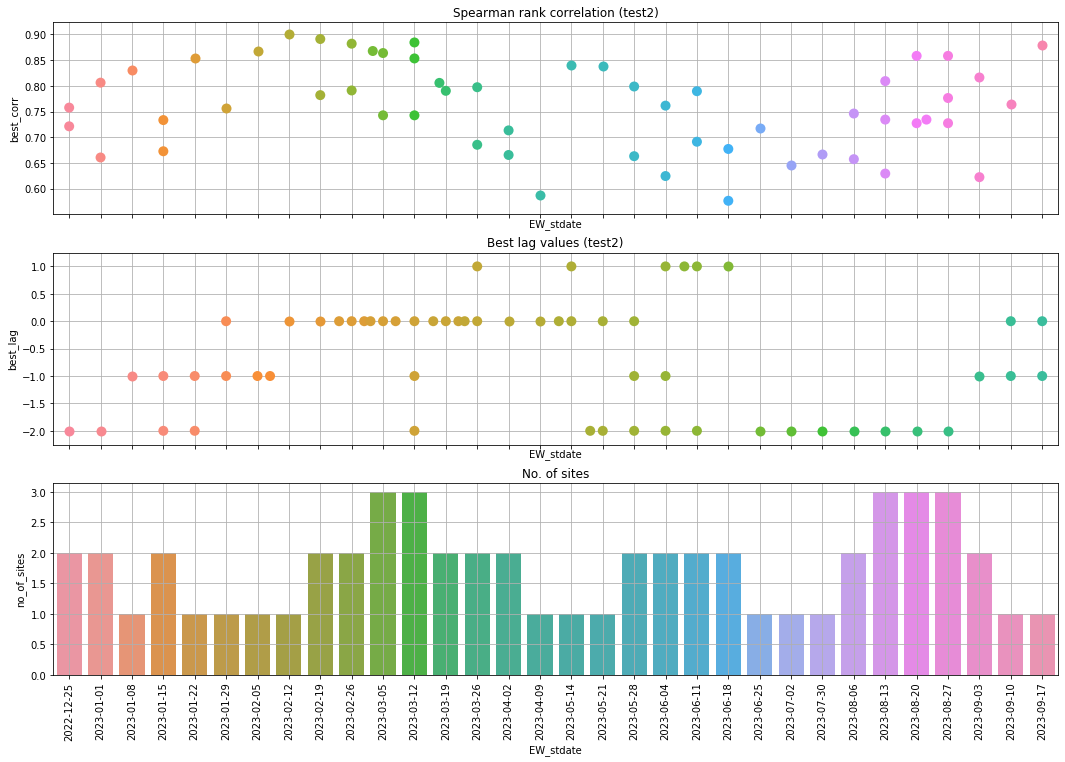

In [119]:
test='test1'
samp='two_tests'
allspdf=pd.read_csv('output/corr_ss/{}_{}.csv'.format(test,samp))
allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})


bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
# bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
# pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
pp=pp.sort_values('EW_stdate')
counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})



fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')


In [110]:
# ppl=bestspdf[bestspdf.best_corr>0].groupby(['sewershed','EW_stdate']).mean()[['best_lag']].reset_index()
# # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
# ppl.EW_stdate=ppl.EW_stdate.dt.strftime('%Y-%m-%d')
# ppl=ppl.sort_values('EW_stdate')

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

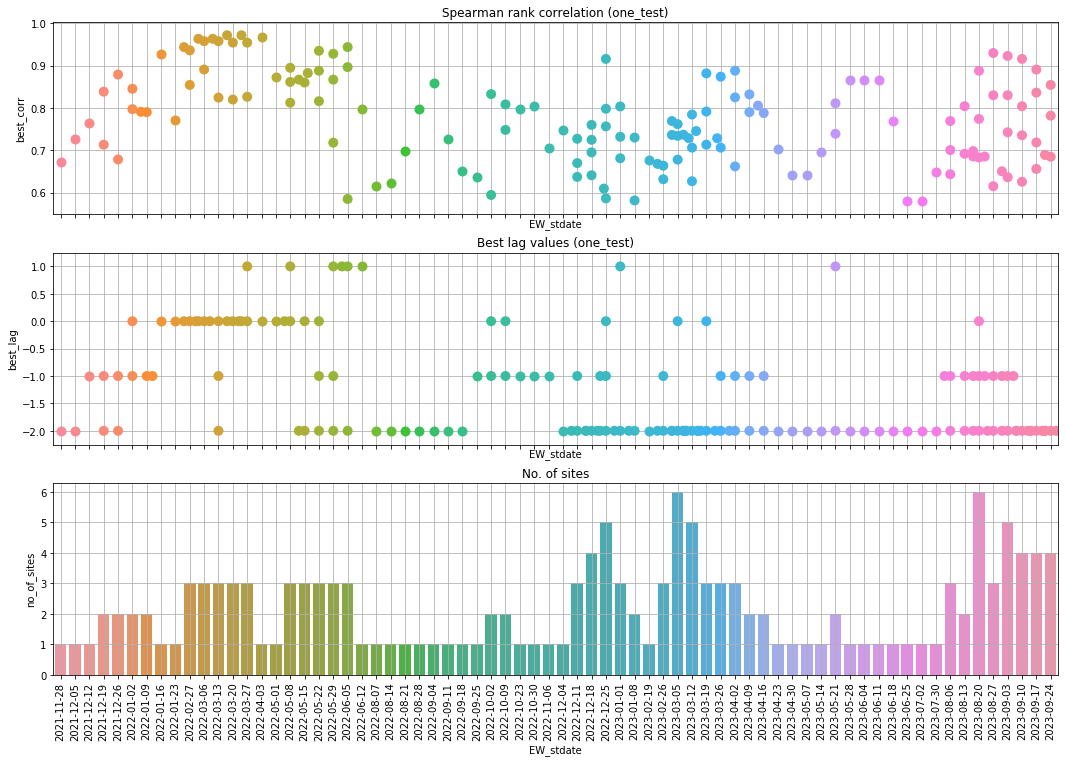

In [111]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')


/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

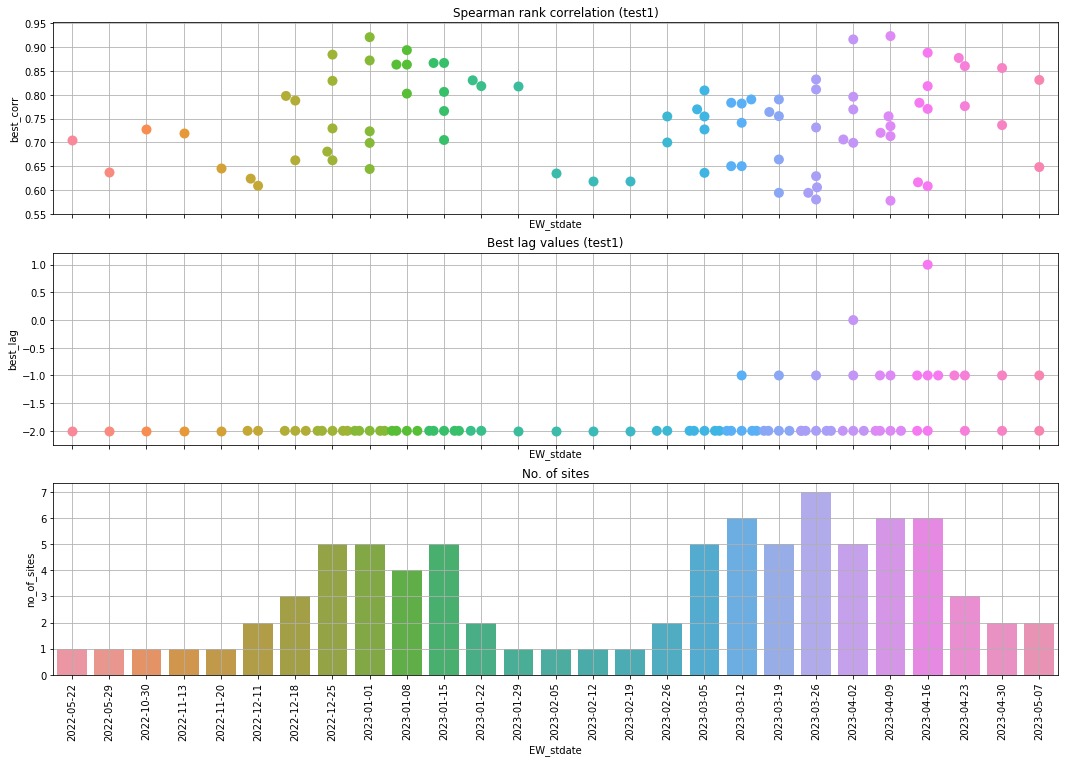

In [491]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')


Text(0.5, 1.0, 'No. of sites')

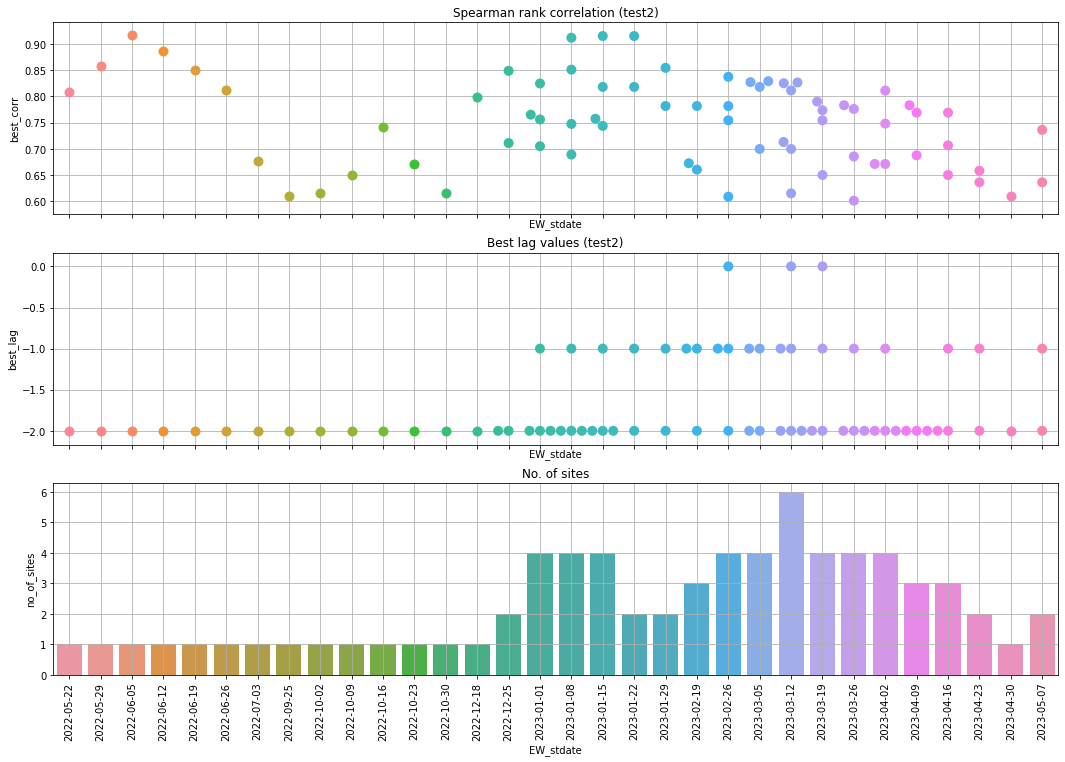

In [495]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')

In [12]:
one_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==1)].sewershed.unique())
two_samp_ss=set(df[(df.sample_collect_date>='2022-09-01')&(df.no_of_samples==2)].sewershed.unique())

In [16]:
only_one_samp=list(one_samp_ss-two_samp_ss)

In [20]:
len(one_samp_ss)

36

In [21]:
locs=only_one_samp
allspdf=pd.DataFrame()
samp='only_one'
if samp=='second':
    test='test2'
elif samp=='first':
    test='test1'
elif samp=='only_one':
    test='only_test1'
for l in locs:
    mdf=pd.read_csv('output/slope_pct/{}_one_samples_ST.csv'.format(l,samp))
    mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
    mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


    hdf=hospdf[hospdf.geo_value==l]
    codf=mdf.merge(hdf)

    temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

    spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
    spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
    spdf.pcorr=spdf.pcorr.fillna(0)
    idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
    bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
    spdf=spdf.merge(bspdf,'outer')
    spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
    allspdf=allspdf.append(spdf)
    print(l)
    allspdf.to_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test),index=None)

FileNotFoundError: [Errno 2] No such file or directory: 'output/slope_pct/Henrico_one_samples_ST.csv'

In [121]:
def get_best_corr_lag(allspdf):
    # allspdf=pd.read_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test))
    allspdf.loc[:,'EW_stdate']=pd.to_datetime(allspdf['EW_stdate'])
    bestspdf=allspdf[['sewershed','EW_stdate','best_lag','best_corr','best_pval']].drop_duplicates()
    bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
    # bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


    pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
    pp=pp.sort_values('EW_stdate')
    counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})


    bestspdf.loc[:,'best_lag']=bestspdf.best_lag.astype(float)
    # bestspdf.loc[:,'best_corr']=bestspdf.best_corr.fillna(0)


    pp=bestspdf.groupby(['sewershed','EW_stdate']).mean()[['best_corr']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    pp.EW_stdate=pp.EW_stdate.dt.strftime('%Y-%m-%d')
    pp=pp.sort_values('EW_stdate')
    counts=pp[pp.best_corr>0].groupby(['EW_stdate']).size().reset_index().rename(columns={0:'no_of_sites'})

    ppl=bestspdf[bestspdf.best_corr>0].groupby(['sewershed','EW_stdate']).mean()[['best_lag']].reset_index()
    # pp.loc[:,'best_corr']=pp.best_corr.fillna(0)
    ppl.EW_stdate=ppl.EW_stdate.dt.strftime('%Y-%m-%d')
    ppl=ppl.sort_values('EW_stdate')
    return pp,ppl

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

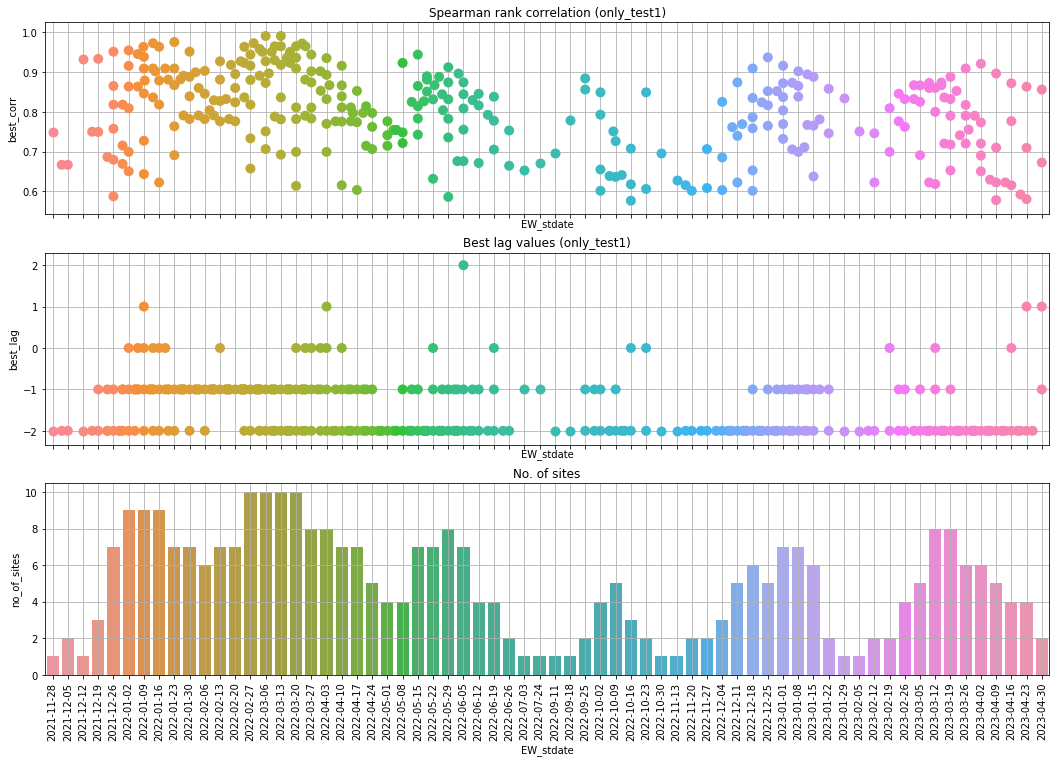

In [45]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')

In [54]:
pop=df[['sewershed','population_served']].drop_duplicates().sort_values(by='population_served',ascending=False)

In [56]:
allspdf.sewershed.unique()

array(['Aquia', 'Virginia Initiative Plant', 'Wolf Creek', 'Richmond',
       'Nansemond', 'Pound', 'Upper Occoquan', 'Little Falls Run',
       'Williamsburg', 'Onancock', 'HL Mooney'], dtype=object)

In [83]:
allspdf=pd.DataFrame()
samp='only_one'
if samp=='second':
    test='test2'
elif samp=='first':
    test='test1'
elif samp=='only_one':
    test='only_test1'
for l in locs:
    mdf=pd.read_csv('output/slope_pct/{}_one_samples_ST.csv'.format(l,samp))
    mdf.loc[:,'EW']=mdf.sample_collect_date.apply(lambda x: conv_epiweek(x))
    mdf.loc[:,'EW_stdate']=mdf.sample_collect_date.apply(lambda x: conv_epiweek_stdate(x))


    hdf=hospdf[hospdf.geo_value==l]
    codf=mdf.merge(hdf)

    temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

    spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
    spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
    spdf.pcorr=spdf.pcorr.fillna(0)
    idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
    bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
    spdf=spdf.merge(bspdf,'outer')
    spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
    allspdf=allspdf.append(spdf)
    print(l)
#     allspdf.to_csv('output/corr_two_samples/{}_sample_correlation.csv'.format(test),index=None)

,sewershed,EW,EW_stdate,population_served,flow_rate,pcr_target_avg_conc,pcr_target_below_lod,lod_sewage,viral_load,no_of_samples,test
0,Alexandria Renew,2022EW38,2022-09-18,300000,33.95,27060.285000,0.0,6200,3.480000e+12,2,test_mean
1,Alexandria Renew,2022EW39,2022-09-25,300000,34.00,30779.875000,0.0,6200,3.965000e+12,2,test_mean
2,Alexandria Renew,2022EW40,2022-10-02,300000,40.05,41755.202500,0.0,6200,6.110000e+12,2,test_mean
3,Alexandria Renew,2022EW41,2022-10-09,300000,35.00,49309.612500,0.0,6200,6.565000e+12,2,test_mean
4,Alexandria Renew,2022EW42,2022-10-16,300000,35.75,32281.850000,0.0,6200,4.360000e+12,2,test_mean
...,...,...,...,...,...,...,...,...,...,...,...
471,RockyMount,2023EW31,2023-07-30,5000,0.55,14881.000000,0.0,6200,3.070000e+10,2,test_mean
472,RockyMount,2023EW32,2023-08-06,5000,0.75,15650.000000,0.0,6200,4.225000e+10,2,test_mean
473,RockyMount,2023EW33,2023-08-13,5000,0.55,26983.000000,0.5,6200,5.600000e+10,2,test_mean
474,RockyMount,2023EW34,2023-08-20,5000,0.50,7659.500000,0.0,6200,1.545000e+10,2,test_mean


In [138]:
dmdf=ddf.groupby(['sewershed','EW'],as_index=False).mean()
dmdf.loc[:,'test']='test_mean'
dmdf.loc[:,'log_viral_load']=np.log10(dmdf['viral_load'])

In [141]:
dmdf=dmdf.merge(hospdf)

In [127]:
locs=dmdf.sewershed.unique()

In [132]:
allspdf=pd.DataFrame()
for l in locs:
    print(l)
    try:
        codf=dmdf[dmdf.sewershed==l]

        temp=codf[['EW_stdate','log_viral_load','hosps_BOW_7d_avg','sewershed']]

        spdf=get_roll_spear(temp,l,shift=[-2,-1,0,1,2])
        spdf=spdf.dropna(subset=['sewershed','EW_stdate'])
        spdf.pcorr=spdf.pcorr.fillna(0)
        idx=spdf[spdf.pval<=0.05].groupby('EW_stdate')['pcorr'].idxmax()
        bspdf=spdf.loc[idx].rename(columns={'lag':'best_lag','pcorr':'best_corr','pval':'best_pval'})
        spdf=spdf.merge(bspdf,'outer')
        spdf.EW_stdate=pd.to_datetime(spdf.EW_stdate)
        allspdf=allspdf.append(spdf)
    except Exception as e:
        print(e)

Alexandria Renew
Blacksburg
Coeburn Norton Wise
North River
Parkins Mill
Timestamp('2023-03-12 00:00:00')
Pepper's Ferry
Roanoke
Moores Creek
Lynchburg
RockyMount


In [133]:
pp,ppl=get_best_corr_lag(allspdf)

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/aa5dw/miniconda3/envs/fct/lib/

Text(0.5, 1.0, 'No. of sites')

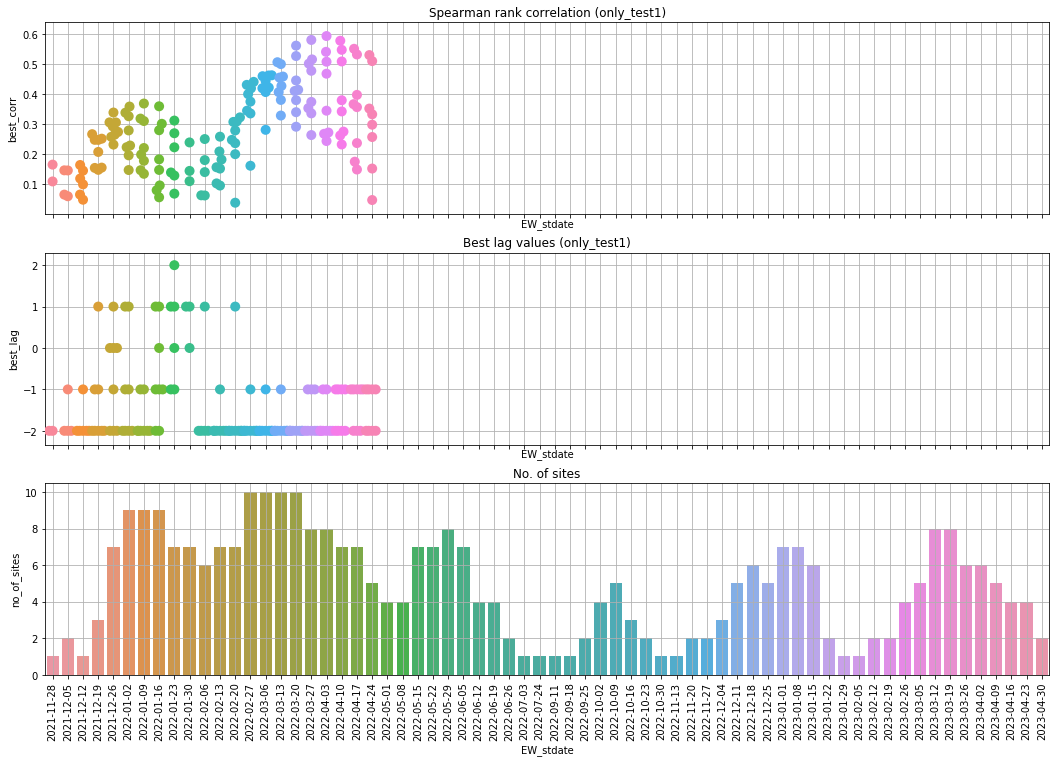

In [136]:
fig,axr=plt.subplots(3,1,figsize=(18,12),sharex=True)
ax=axr[0]
sns.swarmplot(x='EW_stdate', y='best_corr', data=pp[pp.best_corr>0],size=10,ax=ax)
ax.grid()
ax.set_title('Spearman rank correlation ({})'.format(test))
# xticks = ax.get_xticklabels()
# ax.set_xticklabels(xticks,rotation=90)

ax1=axr[1]
# fig,ax1=plt.subplots(1,1,figsize=(18,4),sharex=True)
sns.swarmplot(x='EW_stdate', y='best_lag', data=ppl,size=10,ax=ax1)
ax1.grid()
ax1.set_title('Best lag values ({})'.format(test))
# xticks = ax1.get_xticklabels()
# ax1.set_xticklabels(xticks,rotation=90)

ax2=axr[2]
# fig,ax2=plt.subplots(1,1,figsize=(18,4),sharex=True)
pp[pp.best_corr>0].groupby(['EW_stdate']).size()
sns.barplot(data=counts,x='EW_stdate',y='no_of_sites')
ax2.grid()
xticks = ax2.get_xticklabels()
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_title('No. of sites')

In [8]:
allspdf=pd.read_csv('output/slope_pct/Alexandria Renew_two_samples_ST.csv')

In [9]:
allspdf

,sample_collect_date,viral_load,log_viral_load,log_viral_load_smooth,slope,pct_daily_change,sewershed,slope_smooth,pct_daily_change_smooth
0,2022-09-19,2.890000e+12,12.460898,NaN,NaN,NaN,Alexandria Renew,NaN,NaN
1,2022-09-21,4.070000e+12,12.609594,NaN,NaN,NaN,Alexandria Renew,NaN,NaN
2,2022-09-26,3.500000e+12,12.544068,NaN,0.006192,1.435921,Alexandria Renew,NaN,NaN
3,2022-09-28,4.430000e+12,12.646404,NaN,0.001511,0.348552,Alexandria Renew,NaN,NaN
4,2022-10-03,3.170000e+12,12.501059,NaN,-0.009234,-2.103680,Alexandria Renew,NaN,NaN
...,...,...,...,...,...,...,...,...,...
89,2023-08-16,4.890000e+12,12.689309,12.556000,0.034059,8.158114,Alexandria Renew,0.016222,3.805802
90,2023-08-21,2.190000e+12,12.340444,12.548035,-0.028643,-6.382463,Alexandria Renew,0.003571,0.825721
91,2023-08-23,7.500000e+12,12.875061,12.608943,0.007013,1.627960,Alexandria Renew,0.005077,1.175913
92,2023-08-28,1.990000e+12,12.298853,12.537346,-0.023591,-5.287068,Alexandria Renew,-0.003489,-0.800075
